In [1]:
try:
    already_initialized
except NameError:
    !python -m pip install --upgrade pip
    !pip install spacy==2.3.5
    !pip install spacy-lookups-data
    !python -m spacy download de_core_news_sm
    already_initialized = True

     |████████████████████████████████| 1.6 MB 20.7 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.1.2
    Uninstalling pip-21.1.2:
      Successfully uninstalled pip-21.1.2
     |████████████████████████████████| 10.4 MB 18.2 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 71.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 62.2 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 126 kB 74.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 64.0 MB/s eta 0:00:01
     |████████████████████████████████| 97.3 MB 80.9 MB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 4.2 MB/s eta 0:00:01
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.3.0-py3-none-any.whl size=14907581 sha256=92fe86b4b498dc84bd61a72e5b47c64bc3df1f8703d156cf05fa9ca452ffbdc4
  Stored in directory: /tmp/pip-ephem-wheel-cache-rymr22xo/wheel

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import spacy
import de_core_news_sm
from spacy.lang.de import German
from spacy.matcher import PhraseMatcher
from spacy.gold import GoldParse
from spacy.scorer import Scorer

import random
import pprint
import string
import re
import time
from datetime import datetime
from pathlib import Path

# Load and display data

Our data is stored in a csv file. We load it from disk and shuffle it in order to avoid imbalances between the training, dev and test sets later.
The data contains following columns:
 - **ingredient** contains the ingredient text as we would see it in the recipe
 - **quantity** contains the part of the ingredient text that should be labeled as "quantity" by the model
 - **unit** contains the part of the ingredient text that should be labeled as "unit" by the model
 - **name** contains the part of the ingredient text that should be labeled as "name" by the model 

In [3]:
csv_file = 'data/data.csv'
ingredients_df = pd.read_csv(csv_file).sample(frac=1).reset_index(drop=True) # read and shuffle data

print(f"Total number of rows: {len(ingredients_df.index)}")

# print out the first few rows of data info
ingredients_df.head(10)

Total number of rows: 573


,ingredient,quantity,unit,name
0,1.00 Gläser Weißwein,1.00,Gläser,Weißwein
1,2.00 Zehen Knoblauch,2.00,Zehen,Knoblauch
2,340.00 g Linguiça-Wurst,340.00,g,Linguiça-Wurst
3,2.00 EL Reisessig,2.00,EL,Reisessig
4,3.00 EL Olivenöl,3.00,EL,Olivenöl
5,4.00 EL Leinsamen,4.00,EL,Leinsamen
6,4.00 EL Dattelzucker,4.00,EL,Dattelzucker
7,600.00 g Tagliatelle,600.00,g,Tagliatelle
8,0.52 Tuben Tomatenmark,0.52,Tuben,Tomatenmark
9,1.00 Packungen Mozzarella,1.00,Packungen,Mozzarella


# Helper functions

Here we define some functions we are going to need throughout the implementation.

In [4]:
pprinter = pprint.PrettyPrinter(indent=4)

In [5]:
def pp(title, obj, newline=True):
    """ Convenience function to pretty-print variables """
    print(f'{title}:')
    pprinter.pprint(obj)
    if(newline):
        print()

def split_words(series):
    """  Returns a list of unique words contained in the series """
    unique = set()
    for item in series:
        cleaned = re.sub(r'['+re.escape(string.punctuation)+']', ' ', item)
        cleaned = re.sub(r' +', ' ', cleaned)
        words = cleaned.split()
        for word in words:
            unique.add(word)
    return list(unique)
    
def generate_patterns(model, series):
    """ Converts a series of words as a list of spaCy documents """
    matcher_patterns = []
    
    for item in series:
        pattern = item.lower() if isinstance(item, str) else f'{item:.2f}'
        matcher_patterns.append(model.make_doc(pattern))
    
    return matcher_patterns

def generate_data(model, data, matcher):
    """
    Generates the data used for training the NER model with spaCy.
    Returns a list with entries like this:
    
    ('300.00 g Couscous', {'entities': [(0, 6, 'QUANTITY'), (7, 8, 'UNIT'), (9, 17, 'NAME')]})
    
    """
    RESULT = []
    for doc in model.pipe(data):
        entities = []
        for match_id, start, end in matcher(doc):
            span = doc[start:end]
            label = model.vocab.strings[match_id]
            entity = (span.start_char, span.end_char, label)
            entities.append(entity)

        training_example = (doc.text, {'entities': entities})
        RESULT.append(training_example)
    return RESULT

def evaluate(model, data):
    """ Calculates the f1-score of the model on some data """
    scorer = Scorer()
    for text, annotations in data:
        doc = model.make_doc(text)
        gold = GoldParse(doc, entities=annotations['entities'])
        prediction = model(text)
        scorer.score(prediction, gold)
        # TODO can I get the wrongly labeled examples from the scorer?
    return scorer.scores['ents_f']

def plot_loss(datapoints):
    """ Plots a set of datapoints as a line diagram """
    plt.plot(datapoints)
    plt.ylabel('Loss')
    plt.xlabel('iterations')
    plt.show()

# Generate patterns
We are going to generate patterns we can use for automatically labeling our training data using spaCy.

In [6]:
nlp = de_core_news_sm.load()

UNITS = ingredients_df.unit.unique()

unit_matcher_patterns = generate_patterns(nlp, UNITS, 'UNIT')

pp('Unit pattern examples', unit_matcher_patterns[0:10])

Unit pattern examples:
[gläser, zehen, g, el, tuben, packungen, tl, ml, dosen, bund]



In [7]:
QUANTITIES = ingredients_df.quantity.unique()

quantity_matcher_patterns = generate_patterns(nlp, QUANTITIES, 'QUANTITY')

pp('Quantity pattern examples', quantity_matcher_patterns[0:10])

Quantity pattern examples:
[1.00, 2.00, 340.00, 3.00, 4.00, 600.00, 0.52, 200.00, 66.68, 80.00]



In [8]:
NAMES = ingredients_df.name.unique()

UNIQUE_WORDS = split_words(NAMES)

name_matcher_patterns = generate_patterns(nlp, UNIQUE_WORDS, 'NAME')

pp('Name pattern examples', name_matcher_patterns[0:10])

Name pattern examples:
[   oliven,
    champignons,
    mehl,
    laksapaste,
    maggi,
    kokosmilch,
    garnelen,
    5,
    soja,
    basmati]



# Create Training Data
Now we are going to loop through all the texts in the ingredient column and mark each part (quantity, unit and name) as different entities using the patterns we generated above.

First split the data into a training, a dev, and a test set using a 60% - 20% - 20% split.

In [9]:
# Number of examples - train: 343 - dev: 115 - test: 115
TRAIN_SET, DEV_TEST_SET = train_test_split(ingredients_df, test_size=0.4)
DEV_SET, TEST_SET = train_test_split(DEV_TEST_SET, test_size=0.5)

DEV_TEST_SET = None

total = len(ingredients_df)
train_percent = len(TRAIN_SET) / total
dev_percent = len(DEV_SET) / total
test_percent = len(TEST_SET) / total

print(f'train set: {len(TRAIN_SET)} examples - {train_percent:.0%}') # 343
print(f'  dev set: {len(DEV_SET)} examples - {dev_percent:.0%}')   # 115
print(f' test set: {len(TEST_SET)} examples - {test_percent:.0%}')  # 115

train set: 343 examples - 60%
  dev set: 115 examples - 20%
 test set: 115 examples - 20%


Then use our helper function to convert the different sets into a format suitable for training the spaCy model.

In [10]:
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')
matcher.add('QUANTITY', None, *quantity_matcher_patterns)
matcher.add('UNIT', None, *unit_matcher_patterns)
matcher.add('NAME', None, *name_matcher_patterns)

TRAIN_DATA = generate_data(nlp, TRAIN_SET.ingredient, matcher)
DEV_DATA = generate_data(nlp, DEV_SET.ingredient, matcher)
TEST_DATA = generate_data(nlp, TEST_SET.ingredient, matcher)

pp('TRAIN_DATA', TRAIN_DATA[0:5])
pp('DEV_DATA', DEV_DATA[0:5])
pp('TEST_DATA', TEST_DATA[0:5])

TRAIN_DATA:
[   (   '2.00 TL Italienische Kräuter',
        {   'entities': [   (0, 4, 'QUANTITY'),
                            (5, 7, 'UNIT'),
                            (8, 20, 'NAME'),
                            (21, 28, 'NAME')]}),
    (   '1.00 Kannen Kaffee',
        {'entities': [(0, 4, 'QUANTITY'), (5, 11, 'UNIT'), (12, 18, 'NAME')]}),
    (   '1.00 ml new ingredient',
        {   'entities': [   (0, 4, 'QUANTITY'),
                            (5, 7, 'UNIT'),
                            (8, 11, 'NAME'),
                            (12, 22, 'NAME')]}),
    (   '300.00 g Couscous',
        {'entities': [(0, 6, 'QUANTITY'), (7, 8, 'UNIT'), (9, 17, 'NAME')]}),
    (   '12.00 g Kakaopulver stark entölt',
        {   'entities': [   (0, 5, 'QUANTITY'),
                            (6, 7, 'UNIT'),
                            (8, 19, 'NAME'),
                            (20, 25, 'NAME'),
                            (26, 32, 'NAME')]})]

DEV_DATA:
[   (   '400.00 g Champignons',
      

# Training the Model

Now we are ready to train the model. This model is trained following the recommendations in https://v2.spacy.io/usage/training.

We start with an empty model and a single named-entity recognition (NER) pipeline component.
All 3 labels (quantiy, unit, name) are added to the NER pipeline to be recognized by the model.

After that we loop through the training set, shuffling it before every iteration. The training set is then divided into batches, for which the nlp.update() function is run with the texts and annotations passed as parameters, thus updating the internal weights of the model.

The loss is calculated and tracked for each iteration. It is then plotted into a graph and analyzed to make sure that it gets smaller over time.

This process is repeated for all combinations of hyperparameters (number of iterations, batch size, and dropout rate) which have been defined in advance.

For each hyperparameter combination I then calculated the f1 score on the training set the model was trained on and on the dev set, which the model hadn’t seen yet. One can then informally define the error rate on the training set as the bias and the difference between the dev error rate and the training error rate as the variance. Both bias and variance should be low in order to have a model that performs well and doesn’t overfit.

hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.2} - iteration 0 - loss: {'ner': 128.4235257503744}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.2} - iteration 1 - loss: {'ner': 8.928523578330589}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.2} - iteration 2 - loss: {'ner': 5.135053166255091}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.2} - iteration 3 - loss: {'ner': 5.031490137611167}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.2} - iteration 4 - loss: {'ner': 6.302699749525718}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.2} - iteration 5 - loss: {'ner': 10.89035293112973}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.2} - iteration 6 - loss: {'ner': 4.293319239737265}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.2} - iteration 7 - loss: {'ner': 1.3181057338334325}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.2} - iteration 8 - loss: {'ner': 4.37277439

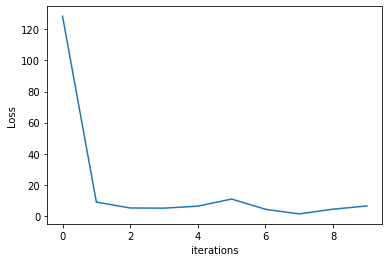

hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.4} - iteration 0 - loss: {'ner': 165.07980859041257}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.4} - iteration 1 - loss: {'ner': 25.202970995361422}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.4} - iteration 2 - loss: {'ner': 8.878371671106795}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.4} - iteration 3 - loss: {'ner': 7.408204731053611}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.4} - iteration 4 - loss: {'ner': 7.216738022417119}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.4} - iteration 5 - loss: {'ner': 7.354469369195164}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.4} - iteration 6 - loss: {'ner': 4.85327720085976}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.4} - iteration 7 - loss: {'ner': 7.698579209230714}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.4} - iteration 8 - loss: {'ner': 6.22895898

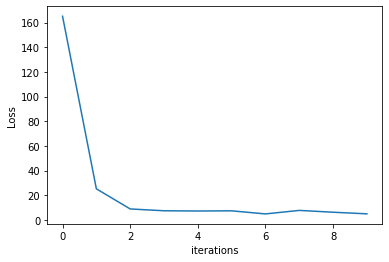

hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.6} - iteration 0 - loss: {'ner': 280.4478206241815}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.6} - iteration 1 - loss: {'ner': 83.86734152701321}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.6} - iteration 2 - loss: {'ner': 49.71271347665124}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.6} - iteration 3 - loss: {'ner': 27.521979458051028}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.6} - iteration 4 - loss: {'ner': 12.877829922420853}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.6} - iteration 5 - loss: {'ner': 19.024854943519315}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.6} - iteration 6 - loss: {'ner': 14.378485439156375}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.6} - iteration 7 - loss: {'ner': 9.700032821214995}
hyper: {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.6} - iteration 8 - loss: {'ner': 11.9944

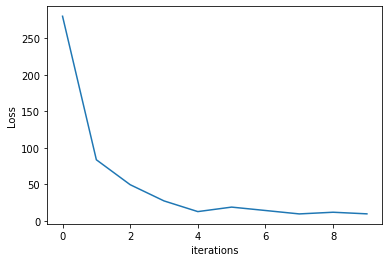

hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.2} - iteration 0 - loss: {'ner': 159.59211190712733}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.2} - iteration 1 - loss: {'ner': 14.69872984078598}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.2} - iteration 2 - loss: {'ner': 4.881851631212615}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.2} - iteration 3 - loss: {'ner': 3.9435725534131043}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.2} - iteration 4 - loss: {'ner': 5.1091017383901445}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.2} - iteration 5 - loss: {'ner': 3.8407306725187267}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.2} - iteration 6 - loss: {'ner': 2.2370249617372076}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.2} - iteration 7 - loss: {'ner': 4.497754836145233}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.2} - iteration 8 - loss: {'ner': 5.3149

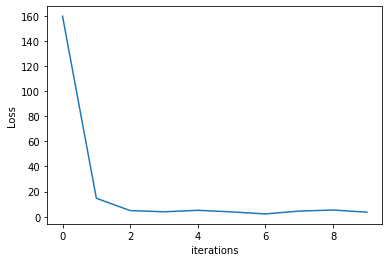

hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.4} - iteration 0 - loss: {'ner': 250.4124416874584}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.4} - iteration 1 - loss: {'ner': 36.16517140687671}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.4} - iteration 2 - loss: {'ner': 19.34584193775163}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.4} - iteration 3 - loss: {'ner': 7.085693696390573}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.4} - iteration 4 - loss: {'ner': 5.716200385504243}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.4} - iteration 5 - loss: {'ner': 7.190030684168083}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.4} - iteration 6 - loss: {'ner': 5.845293587098967}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.4} - iteration 7 - loss: {'ner': 3.4949346018065683}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.4} - iteration 8 - loss: {'ner': 3.68549137

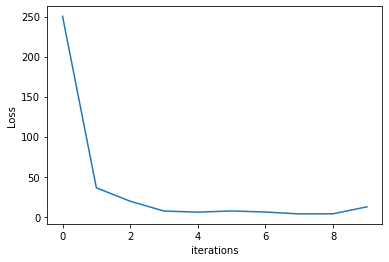

hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.6} - iteration 0 - loss: {'ner': 428.19916439961526}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.6} - iteration 1 - loss: {'ner': 91.12248730901564}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.6} - iteration 2 - loss: {'ner': 81.02471158787002}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.6} - iteration 3 - loss: {'ner': 57.70494834477445}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.6} - iteration 4 - loss: {'ner': 38.539655084563904}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.6} - iteration 5 - loss: {'ner': 28.14579094790103}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.6} - iteration 6 - loss: {'ner': 18.602708878316037}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.6} - iteration 7 - loss: {'ner': 14.455949748359131}
hyper: {'iterations': 10, 'minibatch_size': 4, 'dropout': 0.6} - iteration 8 - loss: {'ner': 7.39835

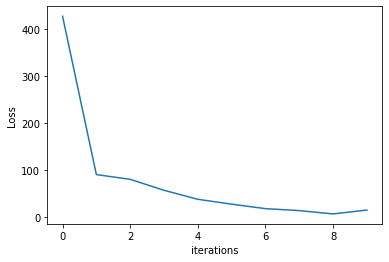

hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.2} - iteration 0 - loss: {'ner': 268.60947002055275}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.2} - iteration 1 - loss: {'ner': 23.745348867876032}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.2} - iteration 2 - loss: {'ner': 7.449846561963729}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.2} - iteration 3 - loss: {'ner': 2.2668970018896366}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.2} - iteration 4 - loss: {'ner': 3.6940020906857853}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.2} - iteration 5 - loss: {'ner': 4.207773815064611}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.2} - iteration 6 - loss: {'ner': 1.9916207120128093}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.2} - iteration 7 - loss: {'ner': 1.6242084308777354}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.2} - iteration 8 - loss: {'ner': 1.674

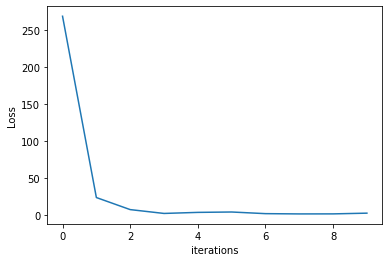

hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.4} - iteration 0 - loss: {'ner': 375.0743622084846}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.4} - iteration 1 - loss: {'ner': 53.64168624454105}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.4} - iteration 2 - loss: {'ner': 19.65958124212597}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.4} - iteration 3 - loss: {'ner': 8.136826783832506}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.4} - iteration 4 - loss: {'ner': 3.7468059493091754}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.4} - iteration 5 - loss: {'ner': 3.128234583092437}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.4} - iteration 6 - loss: {'ner': 5.475992022453272}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.4} - iteration 7 - loss: {'ner': 3.6133598186249363}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.4} - iteration 8 - loss: {'ner': 2.9655271

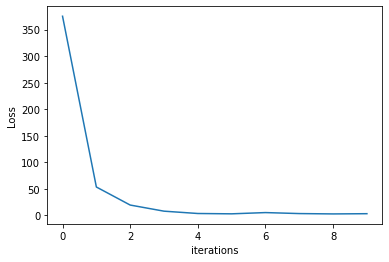

hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.6} - iteration 0 - loss: {'ner': 572.4478903505951}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.6} - iteration 1 - loss: {'ner': 106.42884353599393}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.6} - iteration 2 - loss: {'ner': 79.63406516831232}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.6} - iteration 3 - loss: {'ner': 64.37763976789213}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.6} - iteration 4 - loss: {'ner': 41.67598955299735}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.6} - iteration 5 - loss: {'ner': 27.031494383316353}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.6} - iteration 6 - loss: {'ner': 15.154717576764908}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.6} - iteration 7 - loss: {'ner': 14.990851667907172}
hyper: {'iterations': 10, 'minibatch_size': 8, 'dropout': 0.6} - iteration 8 - loss: {'ner': 13.9880

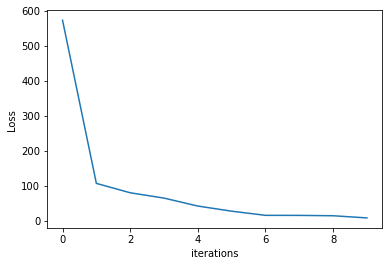

hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.2} - iteration 0 - loss: {'ner': 454.7652188140985}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.2} - iteration 1 - loss: {'ner': 52.48406210743559}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.2} - iteration 2 - loss: {'ner': 18.063980916239107}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.2} - iteration 3 - loss: {'ner': 3.3589620304415835}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.2} - iteration 4 - loss: {'ner': 8.25284269431356}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.2} - iteration 5 - loss: {'ner': 2.1150276496997633}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.2} - iteration 6 - loss: {'ner': 2.775386449315026}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.2} - iteration 7 - loss: {'ner': 1.4432260771358452}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.2} - iteration 8 - loss: {'ner':

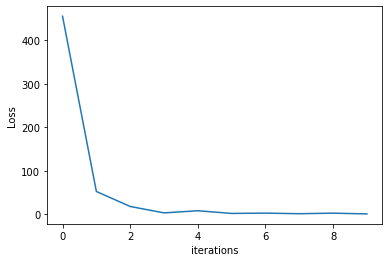

hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.4} - iteration 0 - loss: {'ner': 592.4566035866737}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.4} - iteration 1 - loss: {'ner': 73.2474560344282}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.4} - iteration 2 - loss: {'ner': 49.17397487244118}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.4} - iteration 3 - loss: {'ner': 20.58999931762144}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.4} - iteration 4 - loss: {'ner': 9.567938923613097}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.4} - iteration 5 - loss: {'ner': 9.624681578079445}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.4} - iteration 6 - loss: {'ner': 9.731630254781768}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.4} - iteration 7 - loss: {'ner': 5.452825993304725}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.4} - iteration 8 - loss: {'ner': 6.3

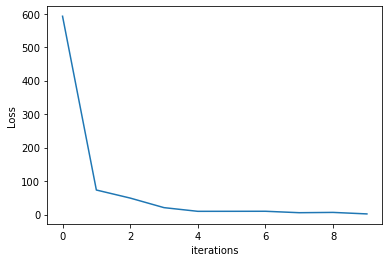

hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.6} - iteration 0 - loss: {'ner': 757.4859988391399}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.6} - iteration 1 - loss: {'ner': 251.94466918124817}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.6} - iteration 2 - loss: {'ner': 94.21734467415013}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.6} - iteration 3 - loss: {'ner': 69.69877699204176}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.6} - iteration 4 - loss: {'ner': 51.59590691873749}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.6} - iteration 5 - loss: {'ner': 47.47872349740795}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.6} - iteration 6 - loss: {'ner': 42.741918770066036}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.6} - iteration 7 - loss: {'ner': 24.403510297596217}
hyper: {'iterations': 10, 'minibatch_size': 16, 'dropout': 0.6} - iteration 8 - loss: {'ner':

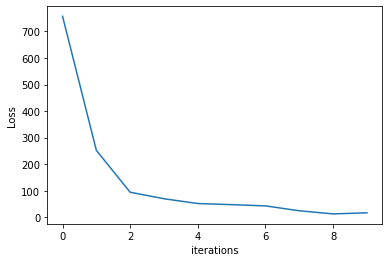

hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.2} - iteration 0 - loss: {'ner': 768.2837406992912}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.2} - iteration 1 - loss: {'ner': 97.73809594970953}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.2} - iteration 2 - loss: {'ner': 40.32256063863227}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.2} - iteration 3 - loss: {'ner': 22.99495235383141}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.2} - iteration 4 - loss: {'ner': 6.085296244569082}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.2} - iteration 5 - loss: {'ner': 5.220591315385065}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.2} - iteration 6 - loss: {'ner': 3.1662337794723383}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.2} - iteration 7 - loss: {'ner': 2.8406476969501084}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.2} - iteration 8 - loss: {'ner': 

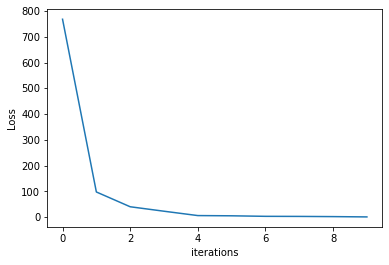

hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.4} - iteration 0 - loss: {'ner': 844.390485227108}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.4} - iteration 1 - loss: {'ner': 245.6984852552414}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.4} - iteration 2 - loss: {'ner': 70.09569048788944}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.4} - iteration 3 - loss: {'ner': 61.19790301568514}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.4} - iteration 4 - loss: {'ner': 36.480940416059745}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.4} - iteration 5 - loss: {'ner': 26.417368047608008}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.4} - iteration 6 - loss: {'ner': 9.239051225750401}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.4} - iteration 7 - loss: {'ner': 5.0603496862483075}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.4} - iteration 8 - loss: {'ner': 

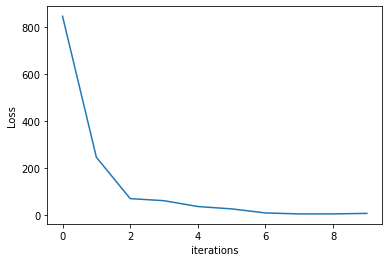

hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.6} - iteration 0 - loss: {'ner': 904.6722567081451}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.6} - iteration 1 - loss: {'ner': 572.8186285495758}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.6} - iteration 2 - loss: {'ner': 257.8718622289598}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.6} - iteration 3 - loss: {'ner': 97.0588361765258}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.6} - iteration 4 - loss: {'ner': 83.07633837747198}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.6} - iteration 5 - loss: {'ner': 74.21831179305445}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.6} - iteration 6 - loss: {'ner': 62.33523625998532}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.6} - iteration 7 - loss: {'ner': 59.75495295981091}
hyper: {'iterations': 10, 'minibatch_size': 32, 'dropout': 0.6} - iteration 8 - loss: {'ner': 48.

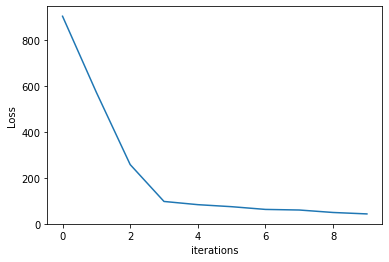

Training the model took 0:10:15.443152


In [11]:
start = datetime.now()

max_iterations = 10
minibatch_sizes = [2, 4, 8, 16, 32]
dropout_values = [0.2, 0.4, 0.6]

result_id = 0
results = []
results_df = pd.DataFrame(columns=['id', 'iterations', 'minibatch_size', 'dropout', 'f1score_train', 'f1score_dev', 'error_train', 'error_dev', 'bias', 'variance'])

for minibatch_size in minibatch_sizes:
    for dropout in dropout_values:
        nlp = spacy.blank('de')
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
        ner.add_label('QUANTITY')
        ner.add_label('UNIT')
        ner.add_label('NAME')
        
        optimizer = nlp.begin_training()

        hyper = {'iterations': max_iterations, 'minibatch_size': minibatch_size, 'dropout': dropout}
        
        loss_history = []
        for iteration in range(hyper['iterations']):
            random.shuffle(TRAIN_DATA)

            losses = {}

            batches = spacy.util.minibatch(TRAIN_DATA, size=hyper['minibatch_size'])
            for batch in batches:
                texts = []
                annotations = []
                for text, entity_offsets in batch:
                    doc = nlp.make_doc(text)
                    gold = GoldParse(doc, entities=entity_offsets['entities'])
                    spacy.gold.biluo_tags_from_offsets(doc, entity_offsets['entities'])
                    texts.append(doc)
                    annotations.append(gold)
                nlp.update(texts, annotations, losses=losses, sgd=optimizer, drop=hyper['dropout'])

            loss_history.append(losses['ner'])
            print(f'hyper: {hyper} - iteration {iteration} - loss: {losses}')
        
        f1score_train = evaluate(nlp, TRAIN_DATA)
        f1score_dev = evaluate(nlp, DEV_DATA)
        error_train = 100.0 - f1score_train
        error_dev = 100.0 - f1score_dev
        bias = error_train
        variance = error_dev - error_train
        
        print(f'hyper: {hyper} - f1-score on TRAIN_DATA : {f1score_train}')
        print(f'hyper: {hyper} - f1-score on DEV_DATA: {f1score_dev}')
        plot_loss(loss_history)
        
        results_df = results_df.append({
            'id': int(result_id), 
            'iterations': hyper['iterations'], 
            'minibatch_size': hyper['minibatch_size'], 
            'dropout': hyper['dropout'], 
            'f1score_train': f1score_train,
            'f1score_dev': f1score_dev,
            'error_train': 100.0 - f1score_train, 
            'error_dev': 100.0 - f1score_dev,
            'bias': bias,
            'variance': variance
        }, ignore_index=True)
        
        results.append({'model': nlp, 'loss_history': loss_history})
        
        result_id += 1

end = datetime.now()

print(f"Training the model took {end - start}")

# Choose the Best Model

A dataframe was created where I could visualize the bias and variance for each combination of hyperparameters in a tabular manner.
After sorting the dataframe by those metrics I then chose the model with the lowest values.

In [12]:
results_df.to_csv('model/model_comparison.csv')

In [13]:
sorted_results_df = results_df.sort_values(['bias', 'variance'])
sorted_results_df.head(20)

,id,iterations,minibatch_size,dropout,f1score_train,f1score_dev,error_train,error_dev,bias,variance
3,3.0,10.0,4.0,0.2,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000
6,6.0,10.0,8.0,0.2,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000
13,13.0,10.0,32.0,0.4,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000
12,12.0,10.0,32.0,0.2,100.000000,99.860530,0.000000,0.139470,0.000000,0.139470
0,0.0,10.0,2.0,0.2,99.953118,99.860530,0.046882,0.139470,0.046882,0.092588
10,10.0,10.0,16.0,0.4,99.953118,99.860530,0.046882,0.139470,0.046882,0.092588
1,1.0,10.0,2.0,0.4,99.906279,100.000000,0.093721,0.000000,0.093721,-0.093721
8,8.0,10.0,8.0,0.6,99.906279,100.000000,0.093721,0.000000,0.093721,-0.093721
9,9.0,10.0,16.0,0.2,99.906279,100.000000,0.093721,0.000000,0.093721,-0.093721
11,11.0,10.0,16.0,0.6,99.906279,100.000000,0.093721,0.000000,0.093721,-0.093721


# Saving Model to Disk

Let's save the model to disk with a suitable name in order to be able to load this model directly at a later point.

In [23]:
best_model = sorted_results_df.iloc[0]
model_id = int(best_model['id'])
model = results[model_id]['model']
model_loss = results[model_id]['loss_history'][-1]
now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'model_{now}_iterations-{best_model.iterations}_batchsize-{best_model.minibatch_size}-dropout-{best_model.dropout}_loss-{model_loss:.2f}'
Path(f'./model').mkdir(parents=True, exist_ok=True)
model.to_disk(f'./model/{model_name}')

# Loading Model from Disk

In [24]:
model_to_load = model_name;
nlp = spacy.load(f'model/{model_to_load}')

# Testing Model

Now let's test the model. For that let's define a function that returns a list of entities found in a given text.

In [29]:
def get_entities(text):
    """ Returns a list of entities found in text """
    doc = nlp(text)
    return [(ent.label_, ent.text) for ent in doc.ents]

Let's now run that function on 10 random datapoints from the test set, which the model hasn't seen before

In [26]:
examples_to_try = 10
for i in range(examples_to_try):
    random.shuffle(TEST_DATA)
    text, _ = TEST_DATA[i]
    print(text, '\n ', get_entities(text))

1.00 TL Knoblauchpulver 
  [('QUANTITY', '1.00'), ('UNIT', 'TL'), ('NAME', 'Knoblauchpulver')]
2.00 Zehen Knoblauch 
  [('QUANTITY', '2.00'), ('UNIT', 'Zehen'), ('NAME', 'Knoblauch')]
600.00 g Möhren 
  [('QUANTITY', '600.00'), ('UNIT', 'g'), ('NAME', 'Möhren')]
3.00 EL Olivenöl 
  [('QUANTITY', '3.00'), ('UNIT', 'EL'), ('NAME', 'Olivenöl')]
40.00 g Kürbiskerne 
  [('QUANTITY', '40.00'), ('UNIT', 'g'), ('NAME', 'Kürbiskerne')]
0.24 TL Oregano 
  [('QUANTITY', '0.24'), ('UNIT', 'TL'), ('NAME', 'Oregano')]
0.52 EL Pimentón (picante) 
  [('QUANTITY', '0.52'), ('UNIT', 'EL'), ('NAME', 'Pimentón'), ('NAME', 'picante')]
40.00 g Mandeln 
  [('QUANTITY', '40.00'), ('UNIT', 'g'), ('NAME', 'Mandeln')]
0.32 Packungen Mandelblättchen 
  [('QUANTITY', '0.32'), ('UNIT', 'Packungen'), ('NAME', 'Mandelblättchen')]
1.00 Dosen Mais 
  [('QUANTITY', '1.00'), ('UNIT', 'Dosen'), ('NAME', 'Mais')]


In [27]:
get_entities('2 tl anis')

[('QUANTITY', '2'), ('UNIT', 'tl'), ('NAME', 'anis')]

It looks good! Our model seems to do well on these examples of the test set.

# Define a Metric

Different types of metrics can be used:
1. accuracy:
  - `(true positives + true negatives) / total`
  - In other words: correctly predicted / total
  - Question accuracy answers: How many selected items were correctly categorized?
2. recall:
  - `true positives / (true positives + false negatives)`
  - In other words: words correctly identified as entities / all words that are entities
  - Question recall answers: How many relevant items are selected?
3. precision:
  - `true positives / (true positives + false positives)`
  - In other words: words correctly identified as entities / words correctly and incorrectly identified as entities
  - Question precision answers: How many selected items are relevant?
4. F1-score:
  - `2 · precision · recall / (precision + recall)`
  - In other words: It tries to optimize both precision and recall. F1-score 1 means perfect precision and recall. F1-score 0 means either precision or recall is zero.

`Accuracy` can be misleading if we have imbalanced data.

`Recall` is in our case more important than `precision`, since we want to catch all ingredients,
and we don't care if some non-ingredients are marked as such, we can just delete them later in the app with a
single click of a button. On the other hand not recognizing ingredients would force us to type them manually.

We still don't want to have too many non-ingredients in our ingredient's list though, so we could use the `F1-Score`
which combines `recall` and `precision` as a metric for our problem.

Another approach could be to use precision as a **satisficing metric** and recall as an **optimizing metric**.

For this problem I am going to use the `F1-Score` as a metric, since it optimizes both for recall and precision and we want both to be reasonably good.

# Evaluating Model

Let's now calculate the **F1-Score** on all 3 sets.

In [28]:
pp('F1 score on TRAIN_DATA', evaluate(nlp, TRAIN_DATA))
pp('F1 score on DEV_DATA', evaluate(nlp, DEV_DATA))
pp('F1 score on TEST_DATA', evaluate(nlp, TEST_DATA))

F1 score on TRAIN_DATA:
100.0

F1 score on DEV_DATA:
100.0

F1 score on TEST_DATA:
99.86130374479889



# Conclusion

Comparing it to the benchmark, which achieved a recall of 99.83% but a precision of 0.26% and hence an f1 score of 0.53%, my model seems to be better suited for my problem since it also optimizes for precision achieving a much higher f1-score, which is the metric we were trying to optimize.

Taking into consideration that my model does well on the test set, which is data the model hasn’t seen before, I would argue this model is suited for this problem and quite robust for this type of data.